# UNN NLP 2021 1st Lab
### Classification task

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np

In [2]:
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


In [3]:
%cd '/content/gdrive/My Drive/UNN-2021-1st-laboratory-work/'

/content/gdrive/My Drive/UNN-2021-1st-laboratory-work


Выполним загрузку данных

In [4]:
df_raw = pd.read_parquet('train.parquet')
df_test = pd.read_parquet('test.parquet')

In [5]:
df_raw.head()

,Body,Tags,Title,target
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1


In [6]:
df_test.head()

,Body,Tags,Title
Id,,,
46785369,I was given a decision tree with sample data i...,<math><machine-learning><artificial-intelligen...,Desecion trees ended up with same given tree a...
38908667,<p>I am moving a test application over to Xcod...,<ios><swift><swift3><xcode8><nserror>,Value of type 'Error' has no member 'code'
44703012,<p>I would like to be able to perform linting ...,<jenkins><jenkins-pipeline>,How do I lint Jenkins pipelines from the comma...
34910435,"<p>I’m using <a href=""https://github.com/ftlab...",<javascript><css><mobile-safari><fastclick.js>...,Is there a way to prevent fastclick from firin...
51632121,I have some 5 Test cases and I want them to ke...,<android><testing><appium><katalon-studio>,How to loop test cases in katalon Studio?


Рассмотрим распределение классов в данных:

<BarContainer object of 3 artists>

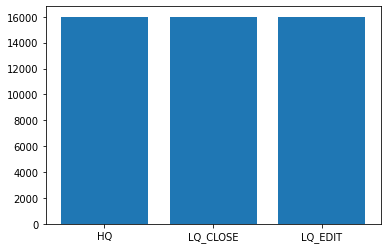

In [7]:
names = ['HQ', 'LQ_CLOSE', 'LQ_EDIT']
values = [len(df_raw[df_raw['target'] == 0]), 
          len(df_raw[df_raw['target'] == 1]), 
          len(df_raw[df_raw['target'] == 2])]

plt.figure(figsize=(6, 4))
plt.bar(names, values)

Вывод: классы распределены равномерно

### Предобработка

Объединим вместе `Title` и `Body` для более удобной работы с ними, а также удалим признак `Tags`.

In [8]:
def df_join(df_raw):
    df_raw['txt'] = df_raw['Title'] + ' ' + df_raw['Body']
    df_train = df_raw.drop(['Tags'], axis=1)
    return df_train

In [9]:
df_train = df_join(df_raw)
df_train

,Body,Title,target,txt
Id,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,I am implementing a Minimum Spanning Forrest a...,2,I am implementing a Minimum Spanning Forrest a...
47303682,"While converting the data frame to HTML, Date ...","R Studio: Date is getting converted to number,...",2,"R Studio: Date is getting converted to number,..."
46431243,"<p>This should be an easy one, but somehow I c...",Pandas - dataframe groupby - how to get sum of...,0,Pandas - dataframe groupby - how to get sum of...
45306324,<p>Let say I have a component in Angular 2 tha...,Casting results from Observable.forkJoin to th...,0,Casting results from Observable.forkJoin to th...
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,Environment variable set in batch file cannot ...,1,Environment variable set in batch file cannot ...
...,...,...,...,...
35488105,<p>Aspx Webpage accepting value in DD/mm/yyyy ...,textbox user control not displaying date in DD...,1,textbox user control not displaying date in DD...
37045803,<p>I am making a program in C#. I want it to d...,C# do something based on image detection,1,C# do something based on image detection <p>I ...
43601747,"<p>The <a href=""https://kafka.apache.org/0100/...",KafkaProducer: Difference between `callback` a...,0,KafkaProducer: Difference between `callback` a...


In [10]:
df_train['txt'] = df_train['txt'].str.lower()

In [11]:
df_train['txt']

Id
34862324    i am implementing a minimum spanning forrest a...
47303682    r studio: date is getting converted to number,...
46431243    pandas - dataframe groupby - how to get sum of...
45306324    casting results from observable.forkjoin to th...
49479547    environment variable set in batch file cannot ...
                                  ...                        
35488105    textbox user control not displaying date in dd...
37045803    c# do something based on image detection <p>i ...
43601747    kafkaproducer: difference between `callback` a...
40505904    is there a way to make github un-approve a pul...
40415937    how to delete more than two array objects in t...
Name: txt, Length: 48000, dtype: object

### Векторизация

##### Bow

In [12]:
from sklearn.feature_extraction.text import CountVectorizer

In [13]:
def bow(X_train, X_val):
    bow_vectorizer = CountVectorizer(stop_words='english')
    X_train = bow_vectorizer.fit_transform(X_train['txt'])
    X_val = bow_vectorizer.transform(X_val['txt'])
    return X_train, X_val

##### Tfidf

In [14]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [15]:
def tf_idf(X_train, X_val):
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train['txt'])
    X_val = vectorizer.transform(X_val['txt'])
    return X_train, X_val

### Разделение данных

In [16]:
df_train, df_val = train_test_split(df_train, test_size=0.15, random_state=11, stratify=df_train['target'])
df_train.shape, df_val.shape, df_test.shape

((40800, 4), (7200, 4), (12000, 3))

In [17]:
y_train = df_train['target'].values
y_val = df_val['target'].values
X_train = df_train.drop(['target'], axis=1)
X_val = df_val.drop(['target'], axis=1)
y_train.shape, y_val.shape, X_train.shape, X_val.shape

((40800,), (7200,), (40800, 3), (7200, 3))

### Классические классификаторы

##### kNN

In [18]:
from sklearn.neighbors import KNeighborsClassifier

In [19]:
def kNN(X_train_vec,y_train,X_val_vec,y_val):
    kNN = KNeighborsClassifier()
    kNN.fit(X_train_vec, y_train)
    y = kNN.predict(X_val_vec)
    print(f1_score(y_val, y, average='macro'))
    return kNN.score(X_val_vec, y_val)

##### LogisticRegression

In [20]:
from sklearn.linear_model import LogisticRegression

In [21]:
def Log_reg(X_train_vec,y_train,X_val_vec,y_val):
    lr = LogisticRegression()
    lr.fit(X_train_vec, y_train)
    y = lr.predict(X_val_vec)
    print(f1_score(y_val, y, average='macro'))
    return lr.score(X_val_vec, y_val)

-----------------------

LogisticRegression + bow

In [22]:
X_train_vec, X_val_vec = bow(X_train, X_val)

In [23]:
LR_score = Log_reg(X_train_vec,y_train,X_val_vec,y_val)
LR_score

0.8033353732876752


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8027777777777778

LogisticRegression + tfidf

In [24]:
X_train_vec, X_val_vec = tf_idf(X_train, X_val)

In [25]:
LR_score = Log_reg(X_train_vec,y_train,X_val_vec,y_val)
LR_score

0.821488984915161


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8225

kNN + bow

In [26]:
X_train_vec, X_val_vec = bow(X_train, X_val)

In [27]:
kNN_score = kNN(X_train_vec,y_train,X_val_vec,y_val)
kNN_score

0.5647138392332417


0.5713888888888888

kNN + tfidf

In [28]:
X_train_vec, X_val_vec = tf_idf(X_train, X_val)

In [29]:
kNN_score = kNN(X_train_vec,y_train,X_val_vec,y_val)
kNN_score

0.6013474490391717


0.6051388888888889

### Embeddings

In [30]:
from nltk.tokenize import WordPunctTokenizer
tokenizer = WordPunctTokenizer()
def tokenize(text):
    return ' '.join(tokenizer.tokenize(text))

In [31]:
def txt_preprocess(text):
    text = tokenize(text)
    return text.lower()

Токенизируем текст из стобца `txt` и применим `lower()` для дальнейшей векторизации

In [32]:
X_train['txt'] = X_train['txt'].apply(txt_preprocess)
X_val['txt'] = X_val['txt'].apply(txt_preprocess)

In [33]:
X_train['txt']

Id
38547307    accessing perl array in bash < p > i have a pe...
36899040    printing arraylist < string > into output ? < ...
36699708    how do i reference and dereference different d...
47857677    having trouble making my website responsive i ...
38228255    need to implement virtual wallet in an ios app...
                                  ...                        
35137280    how to put something on the screen ? < p > i u...
56489569    google apps script replyall on existing thread...
55508326    what is the best way to create a class structu...
55410576    print multiple values from nested dictionaries...
51344028    tslint , enforce spacing between brackets in i...
Name: txt, Length: 40800, dtype: object

##### Word2vec

In [34]:
import gensim
from gensim.models import Word2Vec, KeyedVectors

In [35]:
import gensim.downloader as api
info_datasets = api.info()
print(info_datasets)

{'corpora': {'semeval-2016-2017-task3-subtaskBC': {'num_records': -1, 'record_format': 'dict', 'file_size': 6344358, 'reader_code': 'https://github.com/RaRe-Technologies/gensim-data/releases/download/semeval-2016-2017-task3-subtaskB-eng/__init__.py', 'license': 'All files released for the task are free for general research use', 'fields': {'2016-train': ['...'], '2016-dev': ['...'], '2017-test': ['...'], '2016-test': ['...']}, 'description': 'SemEval 2016 / 2017 Task 3 Subtask B and C datasets contain train+development (317 original questions, 3,169 related questions, and 31,690 comments), and test datasets in English. The description of the tasks and the collected data is given in sections 3 and 4.1 of the task paper http://alt.qcri.org/semeval2016/task3/data/uploads/semeval2016-task3-report.pdf linked in section “Papers” of https://github.com/RaRe-Technologies/gensim-data/issues/18.', 'checksum': '701ea67acd82e75f95e1d8e62fb0ad29', 'file_name': 'semeval-2016-2017-task3-subtaskBC.gz',

In [36]:
from gensim.models.keyedvectors import KeyedVectors
model_w2v = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

Векторизуем наши данные, используя Word2vec:

In [37]:
X_train_w2v = []
for question in X_train['txt']:
    words = question.split()
    X_train_w2v.append(np.mean([model_w2v[word] for word in words if word in model_w2v.vocab], axis=0))

In [38]:
X_val_w2v = []
for question in X_val['txt']:
    words = question.split()
    X_val_w2v.append(np.mean([model_w2v[word] for word in words if word in model_w2v.vocab], axis=0))

In [39]:
len(X_val_w2v), len(X_val_w2v[0])

(7200, 300)

##### GloVe

Векторизуем наши данные, используя GloVe:

In [40]:
from gensim.scripts.glove2word2vec import glove2word2vec
glove_input_file = 'glove.6B.300d.txt'
word2vec_output_file = 'glove.6B.300d.txt.word2vec'
glove2word2vec(glove_input_file, word2vec_output_file)

(400000, 300)

In [41]:
from gensim.models import KeyedVectors
filename = 'glove.6B.300d.txt.word2vec'
model_glove = KeyedVectors.load_word2vec_format(filename, binary=False)

In [42]:
X_train_glove = []
for question in X_train['txt']:
    words = question.split()
    X_train_glove.append(np.mean([model_glove[word] for word in words if word in model_glove.vocab], axis=0))

In [43]:
X_val_glove = []
for question in X_val['txt']:
    words = question.split()
    X_val_glove.append(np.mean([model_glove[word] for word in words if word in model_glove.vocab], axis=0))

In [44]:
len(X_val_glove), len(X_val_glove[0])

(7200, 300)

w2v + lr

In [45]:
LR_score = Log_reg(X_train_w2v,y_train,X_val_w2v,y_val)
LR_score

0.8284382084908123


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8295833333333333

glove + lr

In [46]:
LR_score = Log_reg(X_train_glove,y_train,X_val_glove,y_val)
LR_score

0.8188095521733398


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


0.8198611111111112

w2v + kNN

In [47]:
kNN_score = kNN(X_train_w2v,y_train,X_val_w2v,y_val)
kNN_score

0.7669457226147692


0.7686111111111111

glove + kNN

In [48]:
kNN_score = kNN(X_train_glove,y_train,X_val_glove,y_val)
kNN_score

0.7466616126407523


0.7473611111111111

Используя  Word2vec для линейной регрессии удалось повысить f1_score на $\approx$ 0.00694922357

### NN

In [49]:
df_raw

,Body,Tags,Title,target,txt
Id,,,,,
34862324,Algorithmm:\r\n\r\n**input :** Graph G\r\n\r\n...,<java><algorithm><graph-algorithm>,I am implementing a Minimum Spanning Forrest a...,2,I am implementing a Minimum Spanning Forrest a...
47303682,"While converting the data frame to HTML, Date ...",<html><r><dataframe>,"R Studio: Date is getting converted to number,...",2,"R Studio: Date is getting converted to number,..."
46431243,"<p>This should be an easy one, but somehow I c...",<python><pandas><dataframe><pandas-groupby>,Pandas - dataframe groupby - how to get sum of...,0,Pandas - dataframe groupby - how to get sum of...
45306324,<p>Let say I have a component in Angular 2 tha...,<angular><typescript><rxjs>,Casting results from Observable.forkJoin to th...,0,Casting results from Observable.forkJoin to th...
49479547,<p>I'm setting a var using \n<code>set TEST_VA...,<c><windows><batch-file>,Environment variable set in batch file cannot ...,1,Environment variable set in batch file cannot ...
...,...,...,...,...,...
35488105,<p>Aspx Webpage accepting value in DD/mm/yyyy ...,<c#><asp.net><datetime><textbox>,textbox user control not displaying date in DD...,1,textbox user control not displaying date in DD...
37045803,<p>I am making a program in C#. I want it to d...,<c#><image><detection>,C# do something based on image detection,1,C# do something based on image detection <p>I ...
43601747,"<p>The <a href=""https://kafka.apache.org/0100/...",<java><apache-kafka><kafka-producer-api>,KafkaProducer: Difference between `callback` a...,0,KafkaProducer: Difference between `callback` a...


In [50]:
text_columns = ["Title", "Body"]
categorical_columns = ["Tags"]
target_column = "target"

In [51]:
neural_network_data = df_raw
neural_network_data["Body"] = neural_network_data["Body"].apply(str).apply(str.lower).apply(tokenize)
neural_network_data["Title"] = neural_network_data["Title"].apply(str).apply(str.lower).apply(tokenize)
neural_network_data['target'] = neural_network_data['target'].apply(lambda target: np.eye(3, dtype=np.int32)[target])

In [52]:
from collections import Counter
token_counts = Counter(token for i in text_columns
                             for item in neural_network_data[i]
                             for token in item.split())

Найдем уникальныые токены и их количество, а также постоим гистограмму распределения

In [53]:
print("Total unique tokens:", len(token_counts))
print('\n'.join(map(str, token_counts.most_common(n=5))))
print('...')
print('\n'.join(map(str, token_counts.most_common()[-3:])))

Total unique tokens: 230236
('.', 543501)
('>', 375572)
('p', 225299)
('<', 215383)
(',', 202492)
...
('3bujt', 1)
('9i4jf', 1)
('__nscfarray', 1)


Гистограмма распределения уникальных слов:

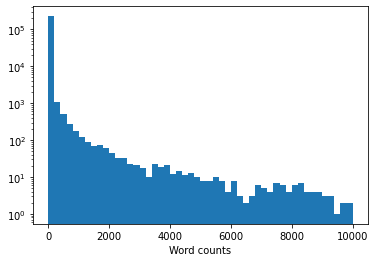

In [54]:
plt.hist(list(token_counts.values()), range=[0, 10**4], bins=50, log=True)
plt.xlabel("Word counts");

Отфильтруем токены, которые встречаются не менее 10 раз по списку всех токенов, также добавим обозначения для пустых и неизвестных слов.

In [55]:
min_count = 10

tokens = sorted(t for t, c in token_counts.items() if c >= min_count)

UNK, PAD = "UNK", "PAD"
tokens = [UNK, PAD] + tokens

print("Vocabulary size:", len(tokens))

Vocabulary size: 24477


Словарь токенов:

In [56]:
token_to_id = dict(map(reversed, enumerate(tokens)))

Преобразуем текстовые и числовые строки в матрицы, усваиваемые нейронной сетью.

In [57]:
UNK_IX, PAD_IX = map(token_to_id.get, [UNK, PAD])

def as_matrix(sequences, max_len=None):

    if isinstance(sequences[0], str):
        sequences = list(map(str.split, sequences))
        
    max_len = min(max(map(len, sequences)), max_len or float('inf'))
    
    matrix = np.full((len(sequences), max_len), np.int32(PAD_IX))
    for i,seq in enumerate(sequences):
        row_ix = [token_to_id.get(word, UNK_IX) for word in seq[:max_len]]
        matrix[i, :len(row_ix)] = row_ix
    
    return matrix  #48000 58 (title)

In [58]:
def num_matrix(arr):
  result = np.zeros((len(arr), 3),dtype=np.int32)
  for i in range(len(arr)):
    for j in range(len(arr[i])):
      result[i][j] = arr[i][j]
  return result

In [59]:
from sklearn.feature_extraction import DictVectorizer

categorical_vectorizer = DictVectorizer(dtype=np.float32, sparse=False)
categorical_vectorizer.fit(neural_network_data[categorical_columns].apply(dict, axis=1))

DictVectorizer(dtype=<class 'numpy.float32'>, sparse=False)

Выполним разделение на `data_train` и `data_val`:

In [60]:
from sklearn.model_selection import train_test_split

data_train, data_val = train_test_split(neural_network_data, test_size=0.15, random_state=11)
data_train.index = range(len(data_train))
data_val.index = range(len(data_val))

print("Train size = ", len(data_train))
print("Validation size = ", len(data_val))

Train size =  40800
Validation size =  7200


In [61]:
import torch

def make_batch(data, max_len=None, word_dropout=0):

    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["Body"] = as_matrix(data["Body"].values, max_len)
    batch["target"] = num_matrix(data["target"].values)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))
    
    if word_dropout != 0:
        batch["Body"] = apply_word_dropout(batch["Body"], 1. - word_dropout)
    
    if target_column in ['Title', 'Body', 'Categorical']:
        batch[target_column] = data[target_column].values
    
    return batch


In [62]:
def apply_word_dropout(matrix, keep_prop, replace_with=UNK_IX, pad_ix=PAD_IX,):
    dropout_mask = np.random.choice(2, np.shape(matrix), p=[keep_prop, 1 - keep_prop])
    dropout_mask &= matrix != pad_ix
    return np.choose(dropout_mask, [matrix, np.full_like(matrix, replace_with)])

Построение сети:

In [63]:
import keras
import keras.layers as L

In [64]:
def build_model(n_tokens=len(tokens), n_cat_features=len(categorical_vectorizer.vocabulary_), hid_size=64):

    l_title = L.Input(shape=[None], name="Title")
    l_body = L.Input(shape=[None], name="Body")
    l_categ = L.Input(shape=[n_cat_features], name="Categorical")
    
    l_title_emb = L.Embedding(n_tokens, hid_size)(l_title)
    l_title_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_title_emb)
    l_title_out = L.GlobalMaxPool1D()(l_title_conv)
    
    
    l_body_emb = L.Embedding(n_tokens, hid_size)(l_body)
    l_body_conv = L.Conv1D(filters=hid_size, kernel_size=2, activation='relu')(l_body_emb)
    l_body_out = L.GlobalMaxPool1D()(l_body_conv)
    
    
    l_categ_fc = L.Dense(hid_size, activation='relu')(l_categ)
    l_categ_out = L.Dense(hid_size)(l_categ_fc)
    
    l_concat = L.Concatenate()([l_title_out, l_body_out, l_categ_out])

    l_fc = L.Dense(hid_size, activation='relu')(l_concat)
    output_fc = L.Dense(3)(l_fc)

    output_layer = L.Softmax()(output_fc)    
    
    model = keras.models.Model(inputs=[l_title, l_body, l_categ], outputs=[output_layer])
    model.compile('adam', 'mean_squared_error', metrics=['categorical_accuracy'])
    return model

In [65]:
model = build_model()
model.summary()

dummy_pred = model.predict(make_batch(data_train[:100]))
dummy_loss = model.train_on_batch(make_batch(data_train[:100]), num_matrix(data_train['target'][:100]))[0]

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Title (InputLayer)             [(None, None)]       0           []                               
                                                                                                  
 Body (InputLayer)              [(None, None)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, None, 64)     1566528     ['Title[0][0]']                  
                                                                                                  
 embedding_1 (Embedding)        (None, None, 64)     1566528     ['Body[0][0]']                   
                                                                                              

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:559: UserWarning: Input dict contained keys ['target'] which did not match any model input. They will be ignored by the model.
  inputs = self._flatten_to_reference_inputs(inputs)


In [66]:
def iterate_minibatches(data, batch_size=256, shuffle=True, cycle=False, **kwargs):

    while True:
        indices = np.arange(len(data))
        if shuffle:
            indices = np.random.permutation(indices)

        for start in range(0, len(indices), batch_size):
            batch = make_batch(data.iloc[indices[start : start + batch_size]], **kwargs)
            target = batch.pop(target_column)
            yield batch, target
        
        if not cycle: break

In [67]:
batch_size = 256
epochs = 3            
steps_per_epoch = 150 

model = build_model()

model.fit_generator(iterate_minibatches(data_train, batch_size, cycle=True, word_dropout=0.05), 
                    epochs=epochs, steps_per_epoch=steps_per_epoch,
                    
                    validation_data=iterate_minibatches(data_val, batch_size, cycle=True),
                    validation_steps=data_val.shape[0] // batch_size
                   )

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  # This is added back by InteractiveShellApp.init_path()


Epoch 1/3
150/150 [==============================] - 299s 2s/step - loss: 0.0879 - categorical_accuracy: 0.8359 - val_loss: 0.0377 - val_categorical_accuracy: 0.9223
Epoch 2/3
150/150 [==============================] - 261s 2s/step - loss: 0.0179 - categorical_accuracy: 0.9674 - val_loss: 0.0396 - val_categorical_accuracy: 0.9199
Epoch 3/3
150/150 [==============================] - 261s 2s/step - loss: 0.0088 - categorical_accuracy: 0.9838 - val_loss: 0.0382 - val_categorical_accuracy: 0.9241


In [68]:
neural_network_test = df_test
neural_network_test["Body"] = neural_network_test["Body"].apply(str).apply(str.lower).apply(tokenize)
neural_network_test["Title"] = neural_network_test["Title"].apply(str).apply(str.lower).apply(tokenize)

In [69]:
def make_test_batch(data, max_len=None, word_dropout=0):

    batch = {}
    batch["Title"] = as_matrix(data["Title"].values, max_len)
    batch["Body"] = as_matrix(data["Body"].values, max_len)
    batch['Categorical'] = categorical_vectorizer.transform(data[categorical_columns].apply(dict, axis=1))

    if target_column in ['Title', 'Body', 'Categorical']:
        batch[target_column] = data[target_column].values
    
    return batch

In [70]:
pred = model.predict(make_test_batch(neural_network_test))

In [71]:
pred = list(map(np.argmax, pred))

In [72]:
answer = pd.DataFrame(data={'Id':neural_network_test.index.tolist(), 'Predicted': pred})

In [73]:
answer

,Id,Predicted
0,46785369,2
1,38908667,0
2,44703012,0
3,34910435,0
4,51632121,2
...,...,...
11995,37771316,0
11996,59044957,1
11997,57190511,0
11998,35228310,2


In [74]:
answer.to_csv("result.csv", index=False)

Вывод: В качестве финального подхода, для классификации категории поста была выбрана сверточная нейронная сеть (CNN) так как она показала лучшие результаты на валидационной выборке. Была достигнута категориальная точность 92% на `data_val`. Удаление HTML тэгов не помогло повысить результаты. Используя  Word2vec для линейной регрессии удалось повысить f1_score с 0.821488984915161 до 0.8284382084908123.